<a href="https://colab.research.google.com/github/joseortegalabra/Proyect-GANs/blob/master/pix2pix_modelo_prueba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
import os
import time
from matplotlib import pyplot as plt

from IPython import display

In [12]:
#como se menciona en el paper se aplica nervisismo y reflejo al conjunto de entrenamiento
#Nerviosismo: la imagen se redimenciona a 286x286 y luego se recorta de forma aleatoria a 256x256
#Reflejo: flip aleatorio horizontal y vertical

# DATA

In [13]:
#imagenes de edificios de praga desde URL
url_data = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz' #link para descargar zip(gz) de las imagenes de edificios

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',    #nombre de archivo original
                                      origin=url_data,    #path donde esta el archivo rar
                                      extract=True)    #descomprimir el rar

30171136/30168306 [==============================] - 3s 0us/step


In [14]:
path = os.path.join(os.path.dirname(path_to_zip), 'facades/')     #path de las imagenes

In [15]:
#paramátros de las iamgenes del data de entrenamiento

BUFFER_SIZE = 400    #cantidad de imagenes de contornos de edificios
BATCH_SIZE = 1     #una imagen por batch
IMG_WIDTH = 256    #ancho y alto
IMG_HEIGHT = 256

In [16]:
#FUNCION PARA LEER UNA IMAGEN DE LA BASE DE DATOS DESDE EL PATH y devuelve el imput y la imagen real

def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)    #obtengo una imagen en el formato jpeg

  w = tf.shape(image)[1]    #la dimensión de ancho de la imagen    

  w = w // 2     #la mitad de la dimensión de ancho porque las imagenes tiene la real a la izquierda y el contorno a la derecha
  real_image = image[:, :w, :]       #mitad de la izquierda imagen real
  input_image = image[:, w:, :]      #mitad de la derecha imagen input (contorno del edificio)

  input_image = tf.cast(input_image, tf.float32)    #tansformar la imagen a formato de tensorflow
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

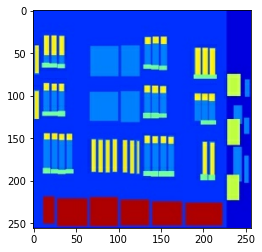

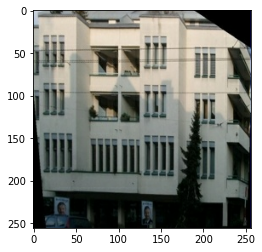

In [17]:
#ejemplo de los datos de train - primera imagen

input_example, real_example = load(path+'train/1.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(input_example/255.0)
plt.figure()
plt.imshow(real_example/255.0)

# DATA AUGMETATION

In [18]:
#funcion para redimensionar la imagen
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [19]:
#funcion para recortar la imagen de forma aleatoria
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])     #IMG_HEIGHT, IMG_WIDTH no estan definidos dentro de la funcion error variable global en un funcion local

  return cropped_image[0], cropped_image[1]

In [20]:
# normalizar imagenes, el input y el real a una escala [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [21]:
#hacer las transformaciones del nerviosismos, redimencionar a una dimension más grande y luego recortar a forma aleatoria

@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

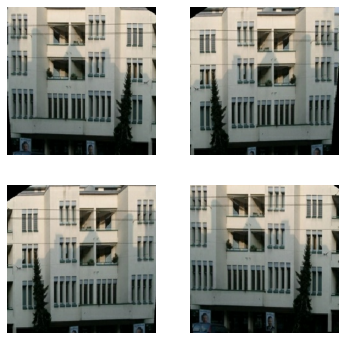

In [22]:
#EJEMPLO DE GRAFICAR LA IMAGEN DE MUESTRA CON LAS TRANSFORMACIONES  de la imagen rel

plt.figure(figsize=(6, 6))
for i in range(4):
  input_example_augmentation, real_example_augmetation = random_jitter(input_example, real_example)
  plt.subplot(2, 2, i+1)
  plt.imshow(real_example_augmetation/255.0)
  plt.axis('off')
plt.show()

In [23]:
#TRAIN
#FUNCIONES CREADAS PARA UNA IMAGEN

#FUNCIION PARA LEER UNA IMAGEN DESDE EL PATH Y HACER EL DATA AUGMENTATION Y DEVUELVE LA IMAGEN LISTA PARA PASAR AL ENTRENEMAIENTO DE LA RED
def load_image_train(image_file):   #le paso el path de la imagen
  input_image, real_image = load(image_file)   #leo la imagen desde el path y devuelvo la imagen original imput y original real
  input_image, real_image = random_jitter(input_image, real_image)   #hago las transformaciones de data augmentation 
  input_image, real_image = normalize(input_image, real_image)   #normalizo la imagen -1, 1

  return input_image, real_image

In [24]:
#TEST
#FUNCIONES CREADAS PARA UNA IMAGEN
def load_image_test(image_file):   #le paso el path de una imagen de test
  input_image, real_image = load(image_file)   #cargo la imagen y obtengo el input y el real
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)     # variables globales # ORIGINALMENTE YA DEBERIA ESTAR EN 256 :?
  input_image, real_image = normalize(input_image, real_image)  #normalizar las imagenes de test

  return input_image, real_image

### Pipeline

In [25]:
# crear el pipeline para tener la imagen en el dataset de tensorflow

In [26]:
# PIPELINE DATASET TRAIN

#crear dataset de train con los archivos originales
train_dataset = tf.data.Dataset.list_files(path+'train/*.jpg')       #crear el data set de train con todos los archivos que tienen coincidencia en el nombre

train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)   #funcion map aplica la transformacion a todos los elementos del DATASET

train_dataset = train_dataset.shuffle(BUFFER_SIZE)    #reordenar los datos del dataset

train_dataset = train_dataset.batch(BATCH_SIZE)  #extraer un batch 

In [27]:
# PIPELINE DATASET TEST

test_dataset = tf.data.Dataset.list_files(path+'test/*.jpg')      #crear dataset de test - CON LOS ARCHIVOS ORIGINALES

test_dataset = test_dataset.map(load_image_test)    #aplicar la funcion de separar las imagenes y escalar

test_dataset = test_dataset.batch(BATCH_SIZE)   #get batches

In [28]:
train_dataset   #dataset que tienen las imagenes de input y reales

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

# Crear generator

In [29]:
OUTPUT_CHANNELS = 3

In [30]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)                   #inicializar media y desviacion estandar 

  result = tf.keras.Sequential()      #crear modelo sequencial de keras  - SIEMPRE CREO UN MODELO PORQUE ASI PUEDO LLAMAR ESTA CAPA TANTO PARA GENERADOR Y DISCRIMINADOR Y ME TERMINA FUNCIONANDO COMO UNA FUNCION QUE CREA UNA CAPA CONVOLUSIONAL DEL TAMAÑO QUE QUIERA
  
  #agrego una capa convolusional con cierta cantidad de canales, tamaño de filtro, stride
  result.add( tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))   

  
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())   #aplicar batch normalization en el layer de salida

  result.add(tf.keras.layers.LeakyReLU())   #aplicar funcion de activacion

  return result

In [31]:
#EJEMPLO DE COMO CREAR EL MODELO generator

#CREAR EL MODELO GENERATOR
down_model = downsample(3, 4)      #primera capa convolucional con 3 canales de salida y aplico un filtro de tamaño 4
down_model

In [32]:
input_example.shape    #la imagen de ejemplo leida directamente del path

TensorShape([256, 256, 3])

In [33]:
down_result = down_model(tf.expand_dims(input_example, 0))     #le paso la imagen de ejemplo con las dimensiones correctas

In [34]:
print (down_result.shape)      #a la imagen de muestra le aplico la transformacion de la CNN que funciona como generador

(1, 128, 128, 3)


In [35]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)       #inicializar normal media y desviacion estandar

  result = tf.keras.Sequential()   #modelo sequencial
  #AGREGEAR LA CAPA DE CONVOLUSION TRASPUESTA - la que utilizo cuando creo el modelo generador que tengo ruido y obtengo la imagen falsa
  result.add( tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result    #return es el modelo creado con la capa convolusion traspuesta

In [36]:
#EJEMPLO DE UPSAMPLE
up_model = upsample(3, 4)    #creo el modelo para pasar de ruido a imagen    - ACA PARA SUBIR ES COMO RETROCEDER LA CAPA DE CONVOLUSION

In [37]:
up_result = up_model(down_result)     #paso la imagen obtenida desde la convolusion para hacer la convolusion compuesta

In [38]:
print (up_result.shape)   #LAS MISMAS DIMENSIONES DEL input_example   - retrocedo la convolusion

(1, 256, 256, 3)


In [39]:
######## CREAR GENERADOR
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])       #crear layer input

  #definir lista con la capas convolusionales
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  #definir lista con las capas de deconvolusión
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  #inicializar el kernel de la ultima capa del generador que hace el capa de deconvolusion y me obtiene la imagen falsa que pasa al discriminador
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)



  #ARMAR LA RED DEL GENERADOR
  x = inputs

  # pasar por todas las capas convolusionales del downsampling
  skips = []    #voy guardando los resultados de las capas de downsampling
  for down in down_stack:   #recorro el array con las capas
    x = down(x)    #recorro la red
    skips.append(x)    #guardo los resultados de pasar por cada una de las capas de downsampling

  skips = reversed(skips[:-1])     
  #omite el resultado de la última capa de downsampling (None, 1,1,512) y me quedo hasta la capa de (None, 2,2,512) 
  #y los resultados de pasar por esas capas los guardo invertidos 
  #entonces las dimensiones de largo y ancho del downsampling invertido es el mismo que al pasar por la parte de upsampling de deconvolusional
  #pero la cantidad de canales es distinta



  # Upsampling and establishing the skip connections
  #recorro el listado de las capas de upsampling y de los resultados invertidos que obtuve de downsampling
  for up, skip in zip(up_stack, skips):
    x = up(x)    #hago las capas de convolusion PERO PASANDO EL X QUE OTUVE DEL DOWNSAMPLING AHORA PASA AL UPSAMPLING (donde el upsampling es como la tipica gan donde parto de algo de ruido y voy generando imagenes con eso don deconvolusiones)
    x = tf.keras.layers.Concatenate()([x, skip])    #concatenar los resultados de downsampling con los de upsampling

  x = last(x)    #paso por la ultima capa para obtener la imagen deseada que va al discriminador

  return tf.keras.Model(inputs=inputs, outputs=x)

In [40]:
generator = Generator()    #crear el modelo generador

In [41]:
#GRÁFICO donde muestra mi modelo generador

#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


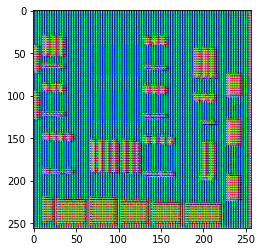

In [42]:
#EJEMPLO DE GENERADOR CON LA IMAGEN DE PRUEBA
gen_output = generator(input_example[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

#### Generator loss

It is a sigmoid cross entropy loss of the generated images and an array of ones.
The paper also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
This allows the generated image to become structurally similar to the target image.
The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.
The training procedure for the generator is shown below:

In [43]:
LAMBDA = 100    #parametro fijado en el paper

In [44]:
#la imagen generada en el discriminador a partir de la imagen creada en el generador, la salida del generador y la imagen real

def generator_loss(disc_generated_output, gen_output, target):     

  #perdida de la gan del generador a partir del valor 0 ó 1 obtenido de pasar la iamgen den generador por el discriminador
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  #norma 1 entre el target y la imagen obtenida en el output del generador
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  #perrida del generador es la suma de la tipica perdida de la gan más la perdida con la norma l1
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

# Crear Discriminador

The Discriminator is a PatchGAN.
Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
The shape of the output after the last layer is (batch_size, 30, 30, 1)
Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
Discriminator receives 2 inputs.
Input image and the target image, which it should classify as real.
Input image and the generated image (output of generator), which it should classify as fake.
We concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))

In [45]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')   #el input de de la red de los datos input contornos de la figura
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')  #el input de la red de los datos reales de la figura

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)   #unir ambas imagenes por los canales

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)  #capas convolucionales definidas a partir del downsampling, entonces creo una capa en el downsalimping con un cierto peso y ahora se la asigno a down1 por lo que despues entreno el down1 y muevo los pesos de esa capa
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256) 
  #cada vez que llamo downsample me crea capas iniciadas de forma aleatoria y que son idependientes entre si.

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (bs, 31, 31, 512)   #penultima capa de convolusion

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)   #ultima capa de convolusion y a la que le pago el path

  #return el model de keras con el input y el output
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [46]:
#EJEMPLO DEL DISCRIMINADOR

#creo el modelo discriminador
discriminator = Discriminator()


In [47]:
#VISUALIZAR DISCRIMINADOR

#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [48]:
#EJEMPLO DE DISCRIMINADOR CON LA IMAGEN DE MUESTRA
disc_out = discriminator([input_example[tf.newaxis,...], gen_output], training=False)   #paso el input real y la salida que tengo desde el generador

In [49]:
disc_out.shape   #la salida de 30x30 que si es cercano a 1 es porque cree que la imagen es real y cero si cree que es ficticia

TensorShape([1, 30, 30, 1])

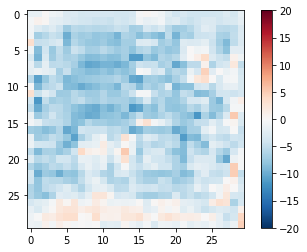

In [50]:
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Discriminator loss

The discriminator loss function takes 2 inputs; real images, generated images
real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since these are the real images)
generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since these are the fake images)
Then the total_loss is the sum of real_loss and the generated_loss

In [51]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [52]:
#misma idea que la red DCGAN

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

# Define the Optimizers and Checkpoint-saver

In [53]:
#definir optimizadores para el generador y el discriminador
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [54]:
#crear los checkpoint 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Generate Images

Write a function to plot some images during training.

We pass images from the test dataset to the generator.
The generator will then translate the input image into the output.
Last step is to plot the predictions and voila!
Note: The training=True is intentional here since we want the batch statistics while running the model on the test dataset. If we use training=False, we will get the accumulated statistics learned from the training dataset (which we don't want)

In [55]:
def generate_images(model, test_input, tar):    #funcion para ir creando imagenes durante el entrenamiento modelo, input de test y la imagen real de test
  
  #hacer una prediccion de la imagen de test con lo que se tiene hecho el modelo hasta ahora
  prediction = model(test_input, training=True)   #training true dicho arriba por qué se deja en true
  #----->obtengo la "prediccion" que es la nueva imagen pintada
  
  #graficar
  plt.figure(figsize=(15,15))

  #IMAGEN A MOSTRAR DURANTE EL ENTRENAMIENTO ES LA PRIMERA IMAGEN DEL CONJUNTO DE TEST - PERO ESTA VIENE DEL DATASET Y POR LO TANTO REORDENA LA IMAGEN Y SOLO ME ENTREGA UNA IMAGEN CUALQUIERA
  display_list = [test_input[0], tar[0], prediction[0]]
  
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

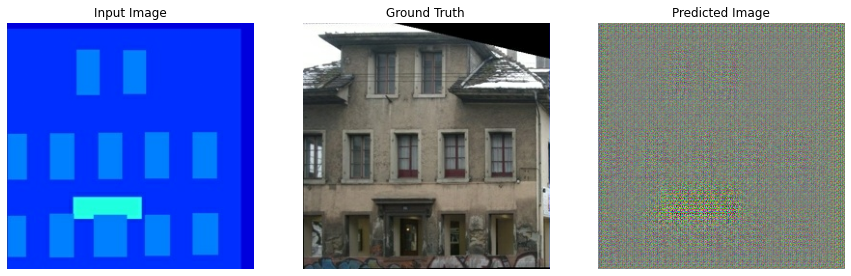

In [58]:
#EJEMPLO DE COMO SE VE LA PRIMERA IMAGEN DE TEST 
for example_input, example_target in test_dataset.take(1):    #tomar una imagen desde el conjunto de dataset de test
  generate_images(generator, example_input, example_target)    #llamar la funcion con la imagen extraida desde dataset de TEST


# Training

For each example input generate an output.
The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
Next, we calculate the generator and the discriminator loss.
Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
Then log the losses to TensorBoard.

In [59]:
EPOCHS = 150   #cantidad de epocas variable global

In [60]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [61]:
@tf.function
def train_step(input_image, target, epoch):
  
  #entrenar con gradient tape
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    #crear imagen ficticia a partir de una imagen de input
    gen_output = generator(input_image, training=True)

    #discriminador de la imagen input con la imagen real
    disc_real_output = discriminator([input_image, target], training=True)
    #discriminador de la imagen input con la imagen generada en el generador
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    #calcular la loss del generador
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    
    # calcular la loss de discriminador
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  #entrenar la red con los gradientes
  
  #calcular gradientes del generador
  generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
  #calcular gradientes del discriminador
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  #aplicar gradiente en el generador
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)


The actual training loop:

Iterates over the number of epochs.
On each epoch it clears the display, and runs generate_images to show it's progress.
On each epoch it iterates over the training dataset, printing a '.' for each example.
It saves a checkpoint every 20 epochs.

In [65]:
train_dataset.enumerate()

<ZipDataset shapes: ((), ((None, 256, 256, 3), (None, 256, 256, 3))), types: (tf.int64, (tf.float32, tf.float32))>

In [66]:
#funcion para entrenar
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()
    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):    #tomo una sola imagen del dataset de test
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)


This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [ ]:
#docs_infra: no_execute
#%load_ext tensorboard
#%tensorboard --logdir {log_dir}

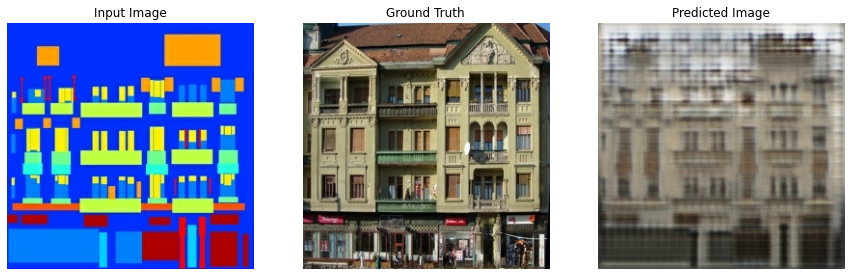

Epoch:  3
..................................................................................

KeyboardInterrupt: ignored

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

# Restore the latest checkpoint and test

In [ ]:
!ls {checkpoint_dir}

In [ ]:
#restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Generate using test dataset

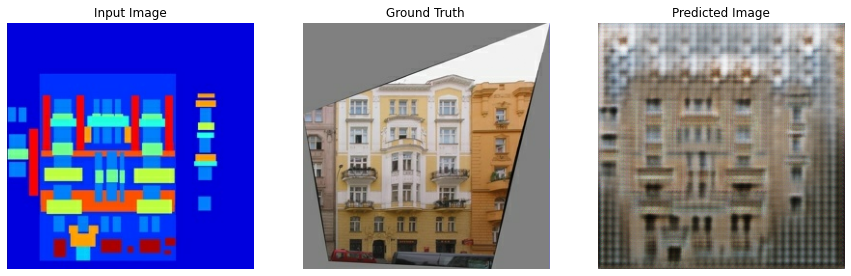

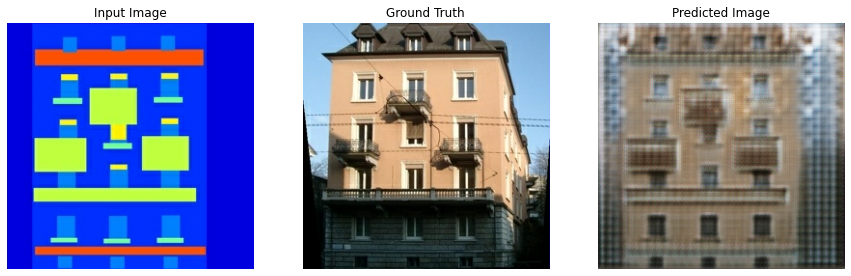

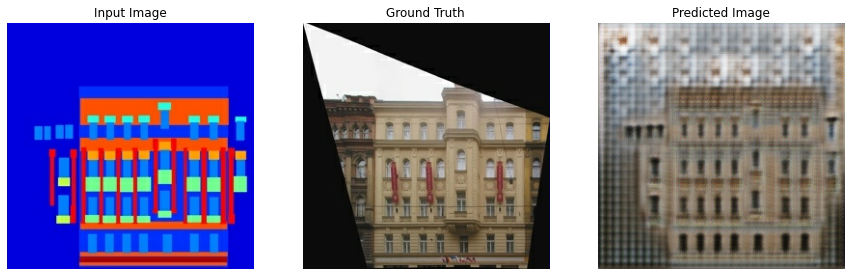

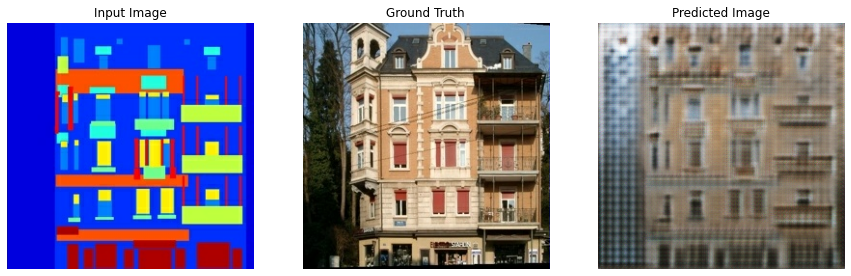

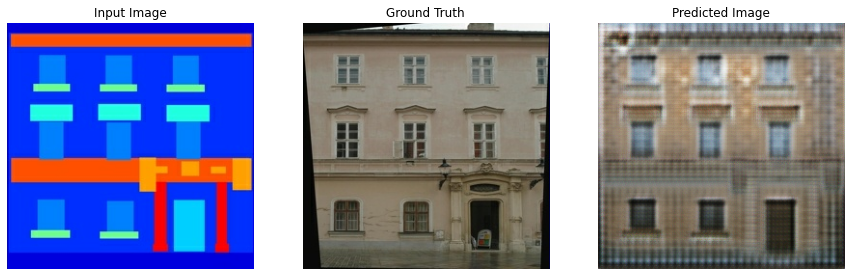

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)